# Entorno

In [1]:
import torch
import torchaudio
import numpy as np
import torch.nn as nn
from random import randint
import pytorch_lightning as pl
from pydub import AudioSegment
from scripts.extract import load_heart_noised_paths
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import CyclicLR, ReduceLROnPlateau
from scripts.plot import plot_audio_sample, plot_prediction_from_tuple
from pytorch_lightning.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    LearningRateMonitor,
)

# Relación de datos

In [2]:
heart_noised = load_heart_noised_paths(
    clean_dir="data/heart_sound",
    noised_dir="data/heart_noised",
)

heart_noised[:3]

[('data/heart_sound/train/healthy/b0123.wav',
  'data/heart_noised/-train-healthy-b0123_seg_454noise_-17dB_louder.wav'),
 ('data/heart_sound/train/healthy/b0123.wav',
  'data/heart_noised/-train-healthy-b0123_seg_550noise_-14dB_louder.wav'),
 ('data/heart_sound/train/healthy/b0123.wav',
  'data/heart_noised/-train-healthy-b0123_seg_106noise_-14dB_louder.wav')]

# Cómo suena?

In [3]:
test = heart_noised[randint(0, len(heart_noised))]

audio_clean = AudioSegment.from_file(test[0])
audio_noisy = AudioSegment.from_file(test[1])

In [4]:
audio_clean

In [5]:
audio_noisy

# Cómo se ve?

In [6]:
clean_array = np.array(audio_clean.get_array_of_samples())
noisy_array = np.array(audio_noisy.get_array_of_samples())
clean_array.shape, noisy_array.shape

((47096,), (47096,))

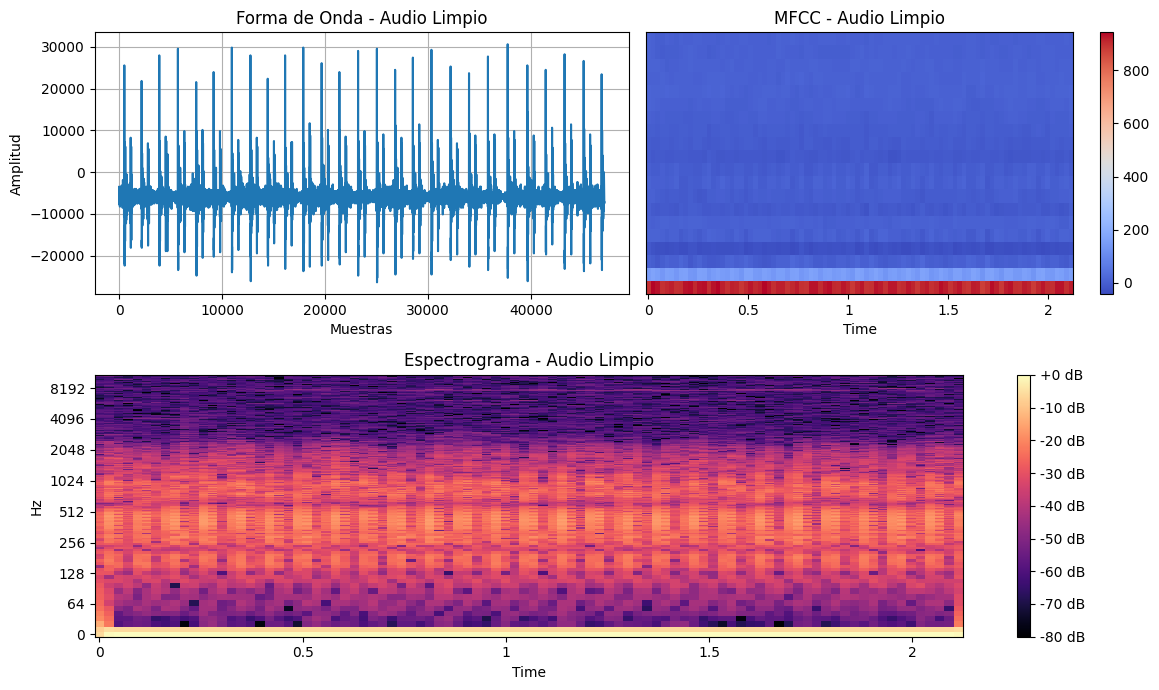

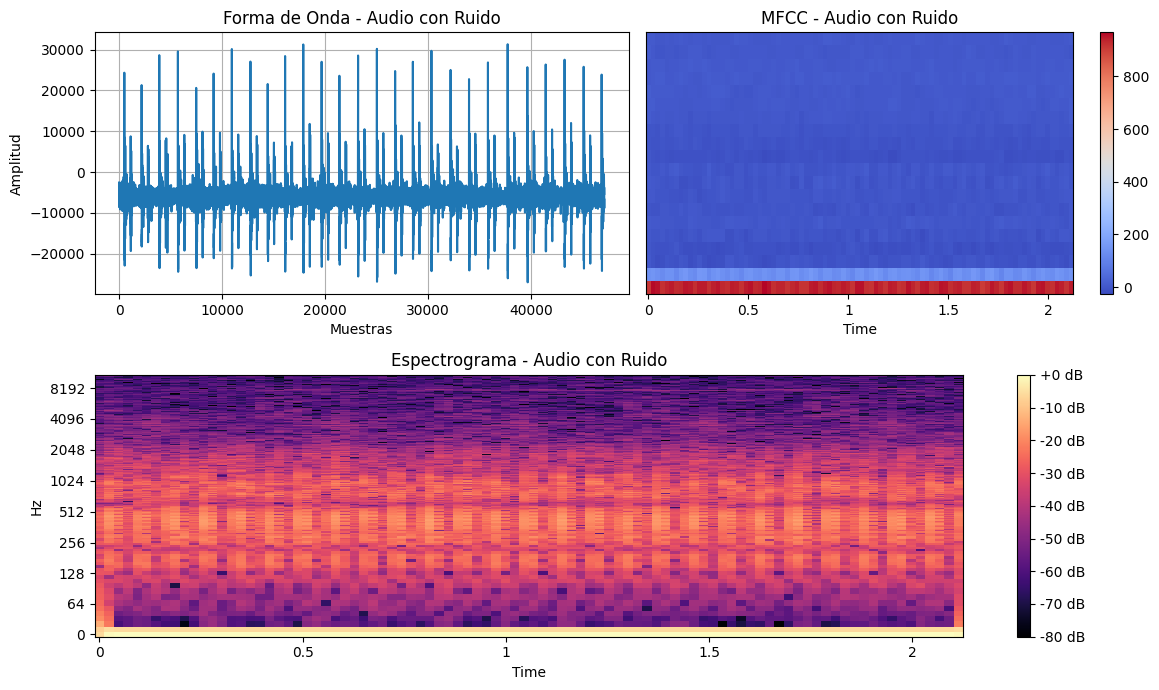

In [7]:
plot_audio_sample(clean_array, "Audio Limpio")
plot_audio_sample(noisy_array, "Audio con Ruido")

# Arquitectura

In [8]:
class DownConvBlock(nn.Module):
    def __init__(self, input_size, output_size, kernel_size=4, norm=True, dropout=0.0):
        super(DownConvBlock, self).__init__()
        self.layers = [nn.Conv2d(input_size, output_size, kernel_size, 2, 1)]
        if norm:
            self.layers.append(nn.InstanceNorm2d(output_size))
        self.layers += [nn.LeakyReLU(0.2)]
        if dropout:
            self.layers += [nn.Dropout(dropout)]

    def forward(self, x):
        op = nn.Sequential(*(self.layers))(x)
        return op


class UpConvBlock(nn.Module):
    def __init__(
        self, input_size, output_size, kernel_size=4, stride=2, padding=1, dropout=0.0
    ):
        super(UpConvBlock, self).__init__()
        self.layers = [
            nn.ConvTranspose2d(
                input_size,
                output_size,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            ),
            nn.InstanceNorm2d(output_size),
            nn.ReLU(),
        ]
        if dropout:
            self.layers += [nn.Dropout(dropout)]

    def forward(self, x, enc_ip):
        x = nn.Sequential(*(self.layers))(x)
        op = torch.cat((x, enc_ip), 1)
        return op


class Autoencoder(pl.LightningModule):
    def __init__(self, input_size):
        super().__init__()
        self.down_conv1 = DownConvBlock(input_size, 64, norm=False)
        self.down_conv2 = DownConvBlock(64, 128)
        self.down_conv3 = DownConvBlock(128, 256)
        self.down_conv4 = DownConvBlock(256, 256, dropout=0.5)
        self.down_conv5 = DownConvBlock(256, 256, dropout=0.5)
        self.down_conv6 = DownConvBlock(256, 256, dropout=0.5)

        self.up_conv1 = UpConvBlock(
            256, 256, kernel_size=(2, 3), stride=2, padding=0, dropout=0.5
        )
        self.up_conv2 = UpConvBlock(
            512, 256, kernel_size=(2, 3), stride=2, padding=0, dropout=0.5
        )
        self.up_conv3 = UpConvBlock(
            512, 256, kernel_size=(2, 3), stride=2, padding=0, dropout=0.5
        )
        self.up_conv4 = UpConvBlock(512, 128, dropout=0.5)
        self.up_conv5 = UpConvBlock(256, 64)
        self.up_conv6 = UpConvBlock(512, 128)
        self.up_conv7 = UpConvBlock(256, 64)

        self.upsample_layer = nn.Upsample(scale_factor=2)
        self.zero_pad = nn.ZeroPad2d((1, 0, 1, 0))
        self.conv_layer_1 = nn.Conv2d(128, input_size, 4, padding=1)
        self.activation = nn.Tanh()

    def forward(self, x):
        enc1 = self.down_conv1(x)
        enc2 = self.down_conv2(enc1)
        enc3 = self.down_conv3(enc2)
        enc4 = self.down_conv4(enc3)
        enc5 = self.down_conv5(enc4)
        enc6 = self.down_conv6(enc5)

        dec1 = self.up_conv1(enc6, enc5)
        dec2 = self.up_conv2(dec1, enc4)
        dec3 = self.up_conv3(dec2, enc3)
        dec4 = self.up_conv4(dec3, enc2)
        dec5 = self.up_conv5(dec4, enc1)

        final = self.upsample_layer(dec5)
        final = self.zero_pad(final)
        final = self.conv_layer_1(final)
        return final

    def training_step(self, batch, batch_idx):
        clean, noisy = batch
        # Forward pass
        decoded = self(noisy)
        # Calculamos la pérdida (error de reconstrucción)
        train_loss = nn.MSELoss()(decoded, clean)
        # Registramos la pérdida para su monitoreo
        self.log("train_loss", train_loss, on_epoch=True)

        return train_loss

    def validation_step(self, batch, batch_idx):
        clean, noisy = batch
        decoded = self(noisy)
        val_loss = nn.MSELoss()(decoded, clean)
        self.log("val_loss", val_loss, on_epoch=True)

        return val_loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        # optimizer = torch.optim.SGD(self.parameters(), lr=0.001, momentum=0.9)

        scheduler = {
            "scheduler": CyclicLR(
                optimizer, base_lr=0.001, max_lr=0.01, cycle_momentum=False
            ),
            "interval": "step",  # Frecuencia de ajuste del LR scheduler (en cada paso)
        }

        # scheduler = {
        #     'scheduler': ReduceLROnPlateau(optimizer, patience=3),
        #     'monitor': 'val_loss',  # Métrica para monitorear
        #     'interval': 'epoch',    # Frecuencia de ajuste del LR scheduler
        #     'frequency': 1          # Igual a interval, ya que estamos usando 'epoch'
        # }

        return [optimizer], [scheduler]

# CustomDataset class

In [9]:
class CoraCleanerDataset(Dataset):
    def __init__(self, data_tuples, transform=None):
        self.data_tuples = data_tuples
        self.transform = transform
        # Calcular la duración mínima de todos los audios
        self.min_duration = self.calculate_min_duration() - 1

    def __len__(self):
        return len(self.data_tuples)

    def calculate_min_duration(self):
        self.durations = []
        for _, audio_path in self.data_tuples:
            audio, _ = torchaudio.load(audio_path)
            self.durations.append(audio.shape[-1])

        return min(self.durations)

    def adjust_audio_duration(self, audio, duration):
        if audio.shape[-1] > duration:
            audio = audio[..., :duration]
        return audio

    def normalize_audio(self, audio):
        normalized = (audio - audio.mean()) / audio.std()
        return normalized.reshape(1, 1, -1)

    def __getitem__(self, idx):
        clean_audio_path = self.data_tuples[idx][0]
        clean_audio, sample_rate = torchaudio.load(clean_audio_path)
        clean_audio = self.adjust_audio_duration(clean_audio, self.min_duration)
        clean_audio = self.normalize_audio(clean_audio)

        noisy_audio_path = self.data_tuples[idx][1]
        noisy_audio, sample_rate = torchaudio.load(noisy_audio_path)
        noisy_audio = self.adjust_audio_duration(noisy_audio, self.min_duration)
        noisy_audio = self.normalize_audio(noisy_audio)

        if self.transform:
            clean_audio = self.transform(clean_audio, sample_rate)
            noisy_audio = self.transform(noisy_audio, sample_rate)

        return clean_audio.view(1, -1, 1), noisy_audio.view(1, -1, 1)

In [10]:
from scripts.transform import spec_n_mfcc

cleaner_dataset = CoraCleanerDataset(heart_noised, spec_n_mfcc)
# cleaner_dataset = CoraCleanerDataset(heart_noised)

print(len(cleaner_dataset))
cleaner_dataset[5][0].shape, cleaner_dataset[5][1].shape

41396


(torch.Size([1, 19649, 1]), torch.Size([1, 19649, 1]))

# Entrenamiento, validación y prueba

In [11]:
batch_size = 16
train_ratio = 0.7
val_ratio = 0.15

train_size = int(train_ratio * len(cleaner_dataset))
val_size = int(val_ratio * len(cleaner_dataset))
test_size = len(cleaner_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    cleaner_dataset, [train_size, val_size, test_size]
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    # num_workers=2,
)
val_dataloader = DataLoader(val_dataset, batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

# Callbacks

In [12]:
checkpoint = ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints/",
    filename="autoencoder-{epoch:02d}-{val_loss:.4f}",
    save_top_k=1,
    mode="min",
)

early_stopping = EarlyStopping(monitor="val_loss", patience=5, mode="min")

lr_monitor = LearningRateMonitor(logging_interval="epoch")

# callbacks = [checkpoint, early_stopping, lr_monitor]
callbacks = [checkpoint, lr_monitor]

# Entrenamiento

In [13]:
input_size = cleaner_dataset[0][0].shape[-1]
model = Autoencoder(input_size=input_size)

logger = TensorBoardLogger("logs/", name="cora_cleaner")

trainer = pl.Trainer(max_epochs=10, callbacks=callbacks, logger=logger)
trainer.fit(model, train_dataloader, val_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/efrainflores/.local/share/virtualenvs/cora_cleaner-eXlQ0b7N/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /Users/efrainflores/Desktop/Nowports/repos/cora_cleaner/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

   | Name           | Type          | Params
--------------------------------------------------
0  | down_conv1     | DownConvBlock | 0     
1  | down_conv2     | DownConvBlock | 0     
2  | down_conv3     | DownConvBlock | 0     
3  | down_conv4     | DownConvBlock | 0     
4  | down_conv5     | DownConvBlock | 0     
5  | down_conv6     | DownConvBlock | 0     
6  | up_conv1       | UpConvBlock   | 0     
7  | up_conv2       | UpConvBlock   | 0     
8  | up_conv3       | UpConvBlock   | 0

Sanity Checking: 0it [00:00, ?it/s]

/Users/efrainflores/.local/share/virtualenvs/cora_cleaner-eXlQ0b7N/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

RuntimeError: Calculated padded input size per channel: (19651 x 3). Kernel size: (4 x 4). Kernel size can't be greater than actual input size

# Predicción

In [ ]:
to_pred = cleaner_dataset[randint(0, len(cleaner_dataset))]

plot_prediction_from_tuple(
    model=model,
    clean_noisy_tuple=to_pred,
    duration=cleaner_dataset.min_duration,
)

In [ ]:
# Descomentar para revisar el Tensorboard en web
# !tensorboard --logdir=path_to_logs_directory

# Otra opción es VisualStudioCode: Ctrl+Shift+P -> Launch Tensorboard